In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((517, 12, 1), (517,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 38s 511ms/step - loss: 0.3468 - root_mean_squared_error: 0.5889 - val_loss: 0.2119 - val_root_mean_squared_error: 0.4603
Epoch 2/50
53/53 [==============================] - 25s 479ms/step - loss: 0.1250 - root_mean_squared_error: 0.3536 - val_loss: 0.0775 - val_root_mean_squared_error: 0.2783
Epoch 3/50
53/53 [==============================] - 25s 475ms/step - loss: 0.0588 - root_mean_squared_error: 0.2425 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2502
Epoch 4/50
53/53 [==============================] - 26s 491ms/step - loss: 0.0426 - root_mean_squared_error: 0.2065 - val_loss: 0.0473 - val_root_mean_squared_error: 0.2174
Epoch 5/50
53/53 [==============================] - 25s 481ms/step - loss: 0.0300 - root_mean_squared_error: 0.1731 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1759
Epoch 6/50
53/53 [==============================] - 26s 501ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462 - val_loss: 0.0227 

53/53 [==============================] - 27s 514ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0815
Epoch 31/50
53/53 [==============================] - 4s 78ms/step - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 32/50
53/53 [==============================] - 4s 66ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 33/50
53/53 [==============================] - 27s 520ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806
Epoch 34/50
53/53 [==============================] - 4s 83ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 35/50
53/53 [==============================] - 4s 83ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0119 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

12.664053066571553 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

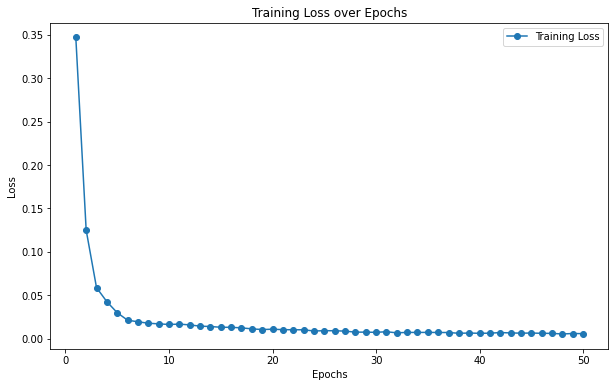

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

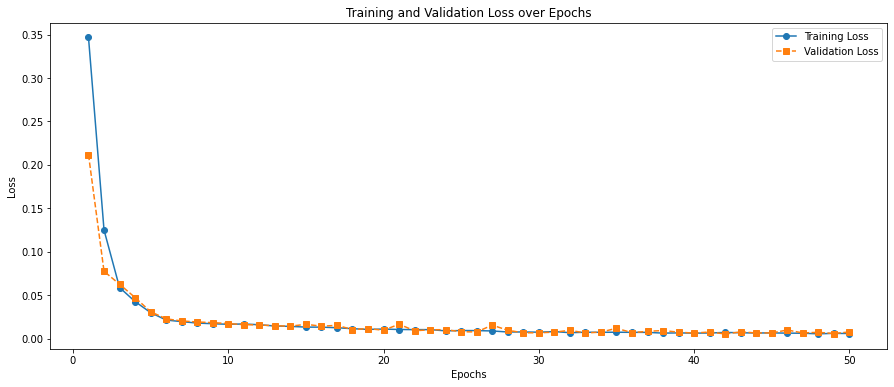

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 23ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.08991771980488868
MAE : 0.06277261010521626


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3.412486e+05,368862.123
1,6.309912e+05,979418.298
2,1.762871e+06,2086269.569
3,2.839968e+06,2852731.016
4,3.297246e+06,3452823.613
5,3.657315e+06,3846843.974
6,3.950718e+06,4005222.451
7,4.076213e+06,4129684.505
8,3.981588e+06,4130311.577
9,3.544969e+06,3987590.376


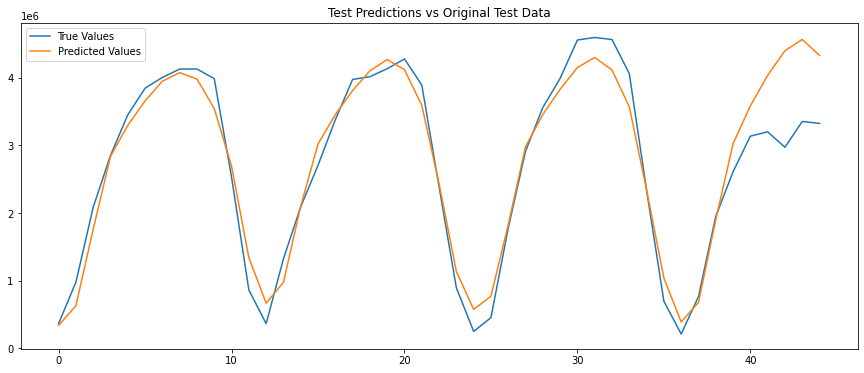

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 39ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

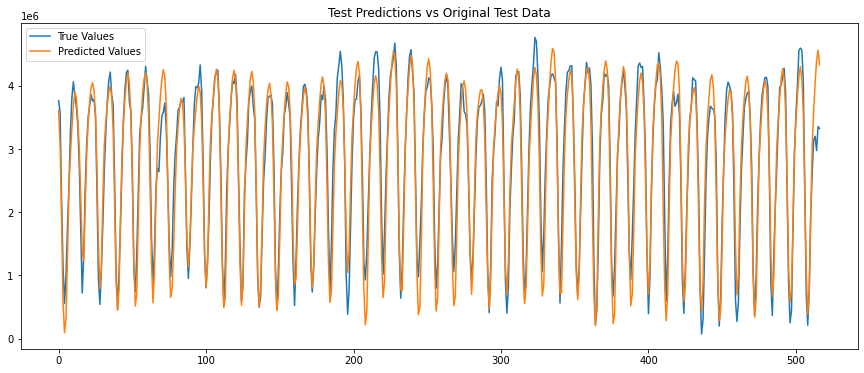

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()